In [1]:
%config Completer.use_jedi = False

import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, DataStructs, Draw
import umap
import matplotlib.pyplot as plt

# Load ligands to dock csv

In [2]:
che_to_dock = pd.read_csv('../data/ChEMBL_ligands_selected_for_docking.csv')
bdb_to_dock = pd.read_csv('../data/BindingDB_ligands_selected_for_docking.csv')

che_to_dock = che_to_dock.rename(columns={'ChEMBL_ID': 'Docked',
                                          'ChEMBL_Smiles': 'Docked_Smiles'
                                         })
bdb_to_dock = bdb_to_dock.rename(columns={'BindingDB_ID': 'Docked',
                                          'BindingDB_Smiles': 'Docked_Smiles'
                                         })
bdb_to_dock['Docked'] = 'BINDINGDB' + bdb_to_dock.Docked.astype(str)

combined_to_dock = pd.concat([che_to_dock, bdb_to_dock], ignore_index=True)
combined_to_dock

,UniProt_ID,BM_Template,BM_Smiles,Docked,Docked_Smiles,Tanimoto_Similarity
0,A4TVL0,6R11_JOB,c1cc2c(cc1N)C(=O)N(C2=O)[C@H]3CC(=O)NC3=O,CHEMBL4455877,Nc1ccc2c(c1)C(=O)N(C1CC(=O)NC1=O)C2=O,1.00
1,A4TVL0,6R1D_JP5,c1ccc(cc1)COC(=O)N[C@H]2CC(=O)NC2=O,CHEMBL4464143,O=C1CC(NC(=O)OCc2ccccc2)C(=O)N1,1.00
2,A4TVL0,6R1D_JP5,c1ccc(cc1)COC(=O)N[C@H]2CC(=O)NC2=O,CHEMBL4556836,NCc1ccc(COC(=O)NC2CC(=O)NC2=O)cc1,0.77
3,A4TVL0,6R1K_JPB,c1c(cc(c(c1Cl)C(=O)N[C@H]2CC(=O)NC2=O)Cl)Cl,CHEMBL4437349,O=C1CC(NC(=O)c2c(Cl)cc(Cl)cc2Cl)C(=O)N1,1.00
4,A5H660,4BZ6_SHH,c1ccc(cc1)NC(=O)CCCCCCC(=O)NO,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,1.00
...,...,...,...,...,...,...
108554,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444029,CC[C@@H](CO)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,1.00
108555,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444030,C[C@@H](CO)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,0.93
108556,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444033,OC[C@H](Cc1ccccc1)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,0.82
108557,Q9ZLT0,2JFZ_003,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,BINDINGDB50421085,CC(C)Cn1c2nn(Cc3cccc4ccccc34)c(-c3cncn3C)c2c(=...,0.75


# Load MCS RMSD dataframes

In [3]:
path_to_poses = '../../docking/dataset/tmp/free_docking/filtered'

In [4]:
all_dfs = []

for folder_name in os.listdir(path_to_poses):

    csv_files = os.listdir(f'{path_to_poses}/{folder_name}/csv')
    
    for csv in csv_files:
        df = pd.read_csv(f'{path_to_poses}/{folder_name}/csv/{csv}')
        all_dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)

In [5]:
docking_mcs_2 = combined_df[combined_df.mcs_rmsd <= 2]
docking_mcs_2 = docking_mcs_2.rename(columns={'Uniprot': 'UniProt_ID',
                                              'Template': 'BM_Template'})

docking_mcs_2

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score
6,O75385,5CI7_51W,BINDINGDB50111573,7,1.935,4258405.794882
13,O75385,5CI7_51W,BINDINGDB50111573,14,1.891,79939.470283
17,O75385,5CI7_51W,BINDINGDB50111573,18,1.003,674279.469954
19,O75385,5CI7_51W,BINDINGDB50111573,20,0.998,705915.705481
23,O75385,5CI7_51W,BINDINGDB50111573,24,1.152,3780522.507046
...,...,...,...,...,...,...
4223309,O15382,5CR5_EL1,BINDINGDB50122747,44,0.970,25475.894072
4223310,O15382,5CR5_EL1,BINDINGDB50122747,45,0.848,657.291223
4223315,O15382,5CR5_EL1,BINDINGDB50122747,50,1.493,123890.527058
4223439,O15382,5CR5_EL1,BINDINGDB50122750,24,1.553,548.790913


In [6]:
docking_mcs_2_unique = docking_mcs_2.loc[docking_mcs_2.groupby(['UniProt_ID', 'BM_Template', 'Docked'])['Hyde_score'].idxmin()].reset_index(drop=True)
docking_mcs_2_unique

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score
0,A4TVL0,6R11_JOB,CHEMBL4455877,14,0.720,193321056031.968475
1,A4TVL0,6R1K_JPB,CHEMBL4437349,20,0.956,11673995375.861568
2,A5H660,4BZ6_SHH,CHEMBL98,1,0.860,1592.26386
3,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,34597.928333
4,A5H660,4BZ8_J38,CHEMBL3800287,46,1.589,8759985.980411
...,...,...,...,...,...,...
58871,Q9Y6F1,4L7R_M00,CHEMBL3092544,15,0.957,239.47318
58872,Q9Y6F1,4L7R_M00,CHEMBL3092553,7,1.662,314.943203
58873,Q9ZLT0,2JFZ_003,BINDINGDB50421085,2,1.737,265.634704
58874,Q9ZLT0,2JFZ_003,CHEMBL401874,17,1.271,133.500902


In [7]:
docking_mcs_2_unique = docking_mcs_2_unique.merge(
    combined_to_dock,
    on=['UniProt_ID', 'BM_Template', 'Docked'],
    how='left'
)

docking_mcs_2_unique 

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score,BM_Smiles,Docked_Smiles,Tanimoto_Similarity
0,A4TVL0,6R11_JOB,CHEMBL4455877,14,0.720,193321056031.968475,c1cc2c(cc1N)C(=O)N(C2=O)[C@H]3CC(=O)NC3=O,Nc1ccc2c(c1)C(=O)N(C1CC(=O)NC1=O)C2=O,1.00
1,A4TVL0,6R1K_JPB,CHEMBL4437349,20,0.956,11673995375.861568,c1c(cc(c(c1Cl)C(=O)N[C@H]2CC(=O)NC2=O)Cl)Cl,O=C1CC(NC(=O)c2c(Cl)cc(Cl)cc2Cl)C(=O)N1,1.00
2,A5H660,4BZ6_SHH,CHEMBL98,1,0.860,1592.26386,c1ccc(cc1)NC(=O)CCCCCCC(=O)NO,O=C(CCCCCCC(=O)Nc1ccccc1)NO,1.00
3,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,34597.928333,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,CN(C)c1ccc(C(=O)NCCCCCCC(=O)NO)cc1,1.00
4,A5H660,4BZ8_J38,CHEMBL3800287,46,1.589,8759985.980411,C[C@@H]1C(=O)Nc2cc(ccc2S1)C(=O)NO,CC1Sc2ccc(C(=O)NO)cc2NC1=O,1.00
...,...,...,...,...,...,...,...,...,...
58871,Q9Y6F1,4L7R_M00,CHEMBL3092544,15,0.957,239.47318,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,CC[C@H](NC(=O)CCc1nc2ccccc2c(=O)[nH]1)c1ccccc1,0.73
58872,Q9Y6F1,4L7R_M00,CHEMBL3092553,7,1.662,314.943203,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,O=C(CCc1nc2ccccc2c(=O)[nH]1)N[C@H](CO)Cc1ccccc1,0.78
58873,Q9ZLT0,2JFZ_003,BINDINGDB50421085,2,1.737,265.634704,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,CC(C)Cn1c2nn(Cc3cccc4ccccc34)c(-c3cncn3C)c2c(=...,0.75
58874,Q9ZLT0,2JFZ_003,CHEMBL401874,17,1.271,133.500902,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,CC(C)Cn1c(=O)n(C)c(=O)c2c(-c3ccncc3)n(Cc3cccc4...,1.00


In [8]:
docking_mcs_2_unique = docking_mcs_2_unique.dropna(subset=['Tanimoto_Similarity']).reset_index(drop=True)
docking_mcs_2_unique

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score,BM_Smiles,Docked_Smiles,Tanimoto_Similarity
0,A4TVL0,6R11_JOB,CHEMBL4455877,14,0.720,193321056031.968475,c1cc2c(cc1N)C(=O)N(C2=O)[C@H]3CC(=O)NC3=O,Nc1ccc2c(c1)C(=O)N(C1CC(=O)NC1=O)C2=O,1.00
1,A4TVL0,6R1K_JPB,CHEMBL4437349,20,0.956,11673995375.861568,c1c(cc(c(c1Cl)C(=O)N[C@H]2CC(=O)NC2=O)Cl)Cl,O=C1CC(NC(=O)c2c(Cl)cc(Cl)cc2Cl)C(=O)N1,1.00
2,A5H660,4BZ6_SHH,CHEMBL98,1,0.860,1592.26386,c1ccc(cc1)NC(=O)CCCCCCC(=O)NO,O=C(CCCCCCC(=O)Nc1ccccc1)NO,1.00
3,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,34597.928333,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,CN(C)c1ccc(C(=O)NCCCCCCC(=O)NO)cc1,1.00
4,A5H660,4BZ8_J38,CHEMBL3800287,46,1.589,8759985.980411,C[C@@H]1C(=O)Nc2cc(ccc2S1)C(=O)NO,CC1Sc2ccc(C(=O)NO)cc2NC1=O,1.00
...,...,...,...,...,...,...,...,...,...
42058,Q9Y6F1,4L7R_M00,CHEMBL3092544,15,0.957,239.47318,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,CC[C@H](NC(=O)CCc1nc2ccccc2c(=O)[nH]1)c1ccccc1,0.73
42059,Q9Y6F1,4L7R_M00,CHEMBL3092553,7,1.662,314.943203,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,O=C(CCc1nc2ccccc2c(=O)[nH]1)N[C@H](CO)Cc1ccccc1,0.78
42060,Q9ZLT0,2JFZ_003,BINDINGDB50421085,2,1.737,265.634704,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,CC(C)Cn1c2nn(Cc3cccc4ccccc34)c(-c3cncn3C)c2c(=...,0.75
42061,Q9ZLT0,2JFZ_003,CHEMBL401874,17,1.271,133.500902,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,CC(C)Cn1c(=O)n(C)c(=O)c2c(-c3ccncc3)n(Cc3cccc4...,1.00


In [9]:
final_docking = docking_mcs_2_unique.loc[docking_mcs_2_unique.groupby(['UniProt_ID', 'Docked'])['Tanimoto_Similarity'].idxmax()].reset_index(drop=True)


In [10]:
final_docking


,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score,BM_Smiles,Docked_Smiles,Tanimoto_Similarity
0,A4TVL0,6R1K_JPB,CHEMBL4437349,20,0.956,11673995375.861568,c1c(cc(c(c1Cl)C(=O)N[C@H]2CC(=O)NC2=O)Cl)Cl,O=C1CC(NC(=O)c2c(Cl)cc(Cl)cc2Cl)C(=O)N1,1.00
1,A4TVL0,6R11_JOB,CHEMBL4455877,14,0.720,193321056031.968475,c1cc2c(cc1N)C(=O)N(C2=O)[C@H]3CC(=O)NC3=O,Nc1ccc2c(c1)C(=O)N(C1CC(=O)NC1=O)C2=O,1.00
2,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,34597.928333,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,CN(C)c1ccc(C(=O)NCCCCCCC(=O)NO)cc1,1.00
3,A5H660,4BZ9_KMY,CHEMBL2094337,19,1.253,18577548.397903,c1ccc2c(c1)c(c(s2)C(=O)NO)Cl,O=C(NO)c1sc2ccccc2c1Cl,1.00
4,A5H660,6HSH_GOK,CHEMBL2105763,19,1.611,21676100.515217,Cn1cc(c2c1cccc2)CNCC3CCN(CC3)c4ncc(cn4)C(=O)NO,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,1.00
...,...,...,...,...,...,...,...,...,...
30294,Q9Y6F1,4L70_1V9,CHEMBL3092544,5,0.571,4.492107,CC[C@@H](c1ccccc1)NC(=O)CCC2=Nc3ccccc3C(=O)N2,CC[C@H](NC(=O)CCc1nc2ccccc2c(=O)[nH]1)c1ccccc1,1.00
30295,Q9Y6F1,4L7L_1VA,CHEMBL3092553,40,1.797,350.168689,c1ccc(cc1)C[C@@H](CO)NC(=O)CCC2=Nc3ccccc3C(=O)N2,O=C(CCc1nc2ccccc2c(=O)[nH]1)N[C@H](CO)Cc1ccccc1,1.00
30296,Q9Y6F1,3C4H_DRL,CHEMBL483348,30,0.603,16962.744041,CC1=NC2=C(CSCC2)C(=O)N1,Cc1nc2c(c(=O)[nH]1)CSCC2,1.00
30297,Q9ZLT0,2JFZ_003,BINDINGDB50421085,2,1.737,265.634704,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,CC(C)Cn1c2nn(Cc3cccc4ccccc34)c(-c3cncn3C)c2c(=...,0.75


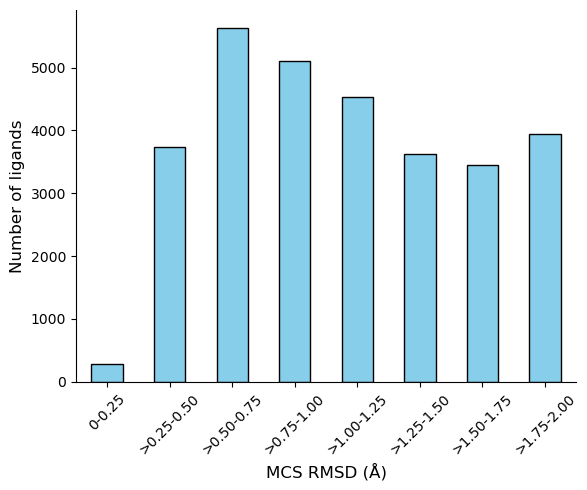

In [75]:
bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, float('inf')]
labels = ['0-0.25', '>0.25-0.50', '>0.50-0.75', 
          '>0.75-1.00', '>1.00-1.25', '>1.25-1.50', 
          '>1.50-1.75', '>1.75-2.00']

final_docking['RMSD_bin'] = pd.cut(final_docking['mcs_rmsd'], bins=bins, labels=labels, include_lowest=True, right=True)

# Count values in each bin
bin_counts = final_docking['RMSD_bin'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6, 5))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("MCS RMSD (Å)", fontsize=12)
plt.ylabel("Number of ligands", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.savefig('../images/mcs_rmsd_dockbind_poses.png', dpi=300, bbox_inches='tight')

plt.show()

In [12]:
print(f'Poses < 1Å: {round(len(final_docking[final_docking.mcs_rmsd <= 1])/len(final_docking), 2)}')
print(f'Poses < 1.5Å: {round(len(final_docking[(final_docking.mcs_rmsd > 1) & (final_docking.mcs_rmsd <= 1.5)])/len(final_docking), 2)}')
print(f'Poses < 1.5Å: {round(len(final_docking[(final_docking.mcs_rmsd <= 1.5)])/len(final_docking), 2)}')


Poses < 1Å: 0.49
Poses < 1.5Å: 0.27
Poses < 1.5Å: 0.76


In [16]:
len(final_docking[final_docking.mcs_rmsd <= 1])

14753

In [13]:
final_docking = final_docking.drop(columns=['RMSD_bin'])
final_docking.to_csv('../data/successfully_docked_ligands.csv', index=False)

In [59]:
final_docking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30299 entries, 0 to 30298
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UniProt_ID           30299 non-null  object 
 1   BM_Template          30299 non-null  object 
 2   Docked               30299 non-null  object 
 3   Pose_ID              30299 non-null  int64  
 4   mcs_rmsd             30299 non-null  float64
 5   Hyde_score           30299 non-null  object 
 6   BM_Smiles            30299 non-null  object 
 7   Docked_Smiles        30299 non-null  object 
 8   Tanimoto_Similarity  30299 non-null  float64
 9   Source               30299 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.3+ MB


# Analysis of the binding affinities in the DockBind dataset

In [2]:
final_docking = pd.read_csv('../data/successfully_docked_ligands.csv')

In [3]:
chembl_affinities = pd.read_csv('../data/ChEMBL_activities_refined.csv',
                                usecols=['UniProt_ID', 'Docked', 'Affinity_Type', 'Binding_Affinity'])
bindbd_affinities = pd.read_csv('../data/BindingDB_activities_refined.csv',
                                usecols=['UniProt_ID', 'Docked', 'Affinity_Type', 'Binding_Affinity'])

affinities_combined = pd.concat([chembl_affinities, bindbd_affinities], ignore_index=True)

print(len(chembl_affinities))
print(len(bindbd_affinities))

affinities_combined.info()

19108
24074
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43182 entries, 0 to 43181
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UniProt_ID        43182 non-null  object 
 1   Docked            43182 non-null  object 
 2   Affinity_Type     43182 non-null  object 
 3   Binding_Affinity  43182 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.3+ MB


In [4]:
# affinities_combined.drop_duplicates(subset=['UniProt_ID', 'Docked'])

In [5]:
final_docking['Source'] = final_docking['Docked'].str.extract(r'^(CHEMBL|BINDINGDB)')
# final_docking

In [6]:
dockbind_baff = final_docking.merge(affinities_combined, on=['UniProt_ID', 'Docked'], how='left').dropna().reset_index(drop=True)
dockbind_baff = dockbind_baff[dockbind_baff.Binding_Affinity != 0]


In [7]:
# Step 1: Filter rows that are Ki or Kd
ki_kd_df = dockbind_baff[dockbind_baff['Affinity_Type'].isin(['Ki (nM)', 'Kd (nM)'])].copy()

# Step 2: Sort to prioritize Kd over Ki (ascending: Kd comes first)
ki_kd_df = ki_kd_df.sort_values(by='Affinity_Type', ascending=True)

# Step 3: Drop duplicates by UniProt_ID and Docked, keeping the first (Kd if available)
ki_kd_unique = ki_kd_df.drop_duplicates(subset=['UniProt_ID', 'Docked'], keep='first')

# Step 4: Keep only IC50 from original DataFrame
ic50_df = dockbind_baff[dockbind_baff['Affinity_Type'] == 'IC50 (nM)'].copy()

# Step 5: Combine the filtered data
filtered_dockbind_baff = pd.concat([ic50_df, ki_kd_unique], ignore_index=True)

In [8]:
dockbind_baff = filtered_dockbind_baff.copy()
dockbind_baff.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31887 entries, 0 to 31886
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UniProt_ID           31887 non-null  object 
 1   BM_Template          31887 non-null  object 
 2   Docked               31887 non-null  object 
 3   Pose_ID              31887 non-null  int64  
 4   mcs_rmsd             31887 non-null  float64
 5   Hyde_score           31887 non-null  float64
 6   BM_Smiles            31887 non-null  object 
 7   Docked_Smiles        31887 non-null  object 
 8   Tanimoto_Similarity  31887 non-null  float64
 9   Source               31887 non-null  object 
 10  Affinity_Type        31887 non-null  object 
 11  Binding_Affinity     31887 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 2.9+ MB


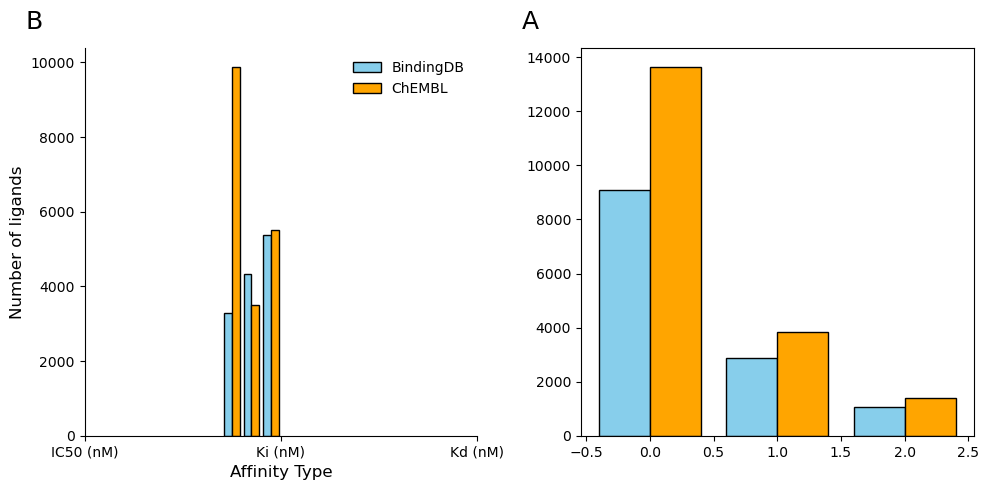

In [14]:
affinity_types = ['IC50 (nM)', 'Ki (nM)', 'Kd (nM)']

bdb_df = dockbind_baff[dockbind_baff['Source'] == 'BINDINGDB']
chembl_df = dockbind_baff[dockbind_baff['Source'] == 'CHEMBL']

bdb_counts = bdb_df['Affinity_Type'].value_counts()
chembl_counts = chembl_df['Affinity_Type'].value_counts()

bdb_vals = [bdb_counts.get(aff, 0) for aff in affinity_types]
chembl_vals = [chembl_counts.get(aff, 0) for aff in affinity_types]

bins = [0.7, 0.8, 0.9, 1.0]
labels = [">0.7-0.8", ">0.8-0.9", ">0.9-1.0"]
centers = 0.5 * (np.array(bins[:-1]) + np.array(bins[1:]))
bar_width_similarity = 0.04  

bdb_tani = bdb_df['Tanimoto_Similarity'].dropna()
chembl_tani = chembl_df['Tanimoto_Similarity'].dropna()

counts_bdb, _ = np.histogram(bdb_tani, bins=bins)
counts_chembl, _ = np.histogram(chembl_tani, bins=bins)

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

x = np.arange(len(affinity_types))
bar_width_affinity = 0.4

# axes[0].bar(centers - bar_width_similarity/2, counts_bdb, width=bar_width_similarity, color='skyblue', edgecolor='black', label='BindingDB')
# axes[0].bar(centers + bar_width_similarity/2, counts_chembl, width=bar_width_similarity, color='orange', edgecolor='black', label='ChEMBL')

# axes[0].set_xticks(centers)
# axes[0].set_xticklabels(labels, fontsize=10)
# axes[0].set_xlabel("Tanimoto Similarity", fontsize=12)
# axes[0].set_ylabel("Number of ligands", fontsize=12)
# axes[0].legend(frameon=False)
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)
# axes[0].text(-0.15, 1.05, 'A', fontsize=18, transform=axes[1].transAxes)


# axes[1].bar(x - bar_width_affinity/2, bdb_vals, width=bar_width_affinity, label='BindingDB', color='skyblue', edgecolor='black')
# axes[1].bar(x + bar_width_affinity/2, chembl_vals, width=bar_width_affinity, label='ChEMBL', color='orange', edgecolor='black')
# axes[1].set_xticks(x)
# axes[1].set_xticklabels(affinity_types, rotation=0)
# axes[1].set_xlabel("Affinity Type", fontsize=12)
# axes[1].set_ylabel("Number of ligands", fontsize=12)
# axes[1].legend(frameon=False)
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)
# axes[1].text(-0.15, 1.05, 'B', fontsize=18, transform=axes[0].transAxes)


# plt.tight_layout()
# plt.savefig('../images/affinity_and_tanimoto_distribution.png', dpi=300, bbox_inches='tight')
# plt.show()


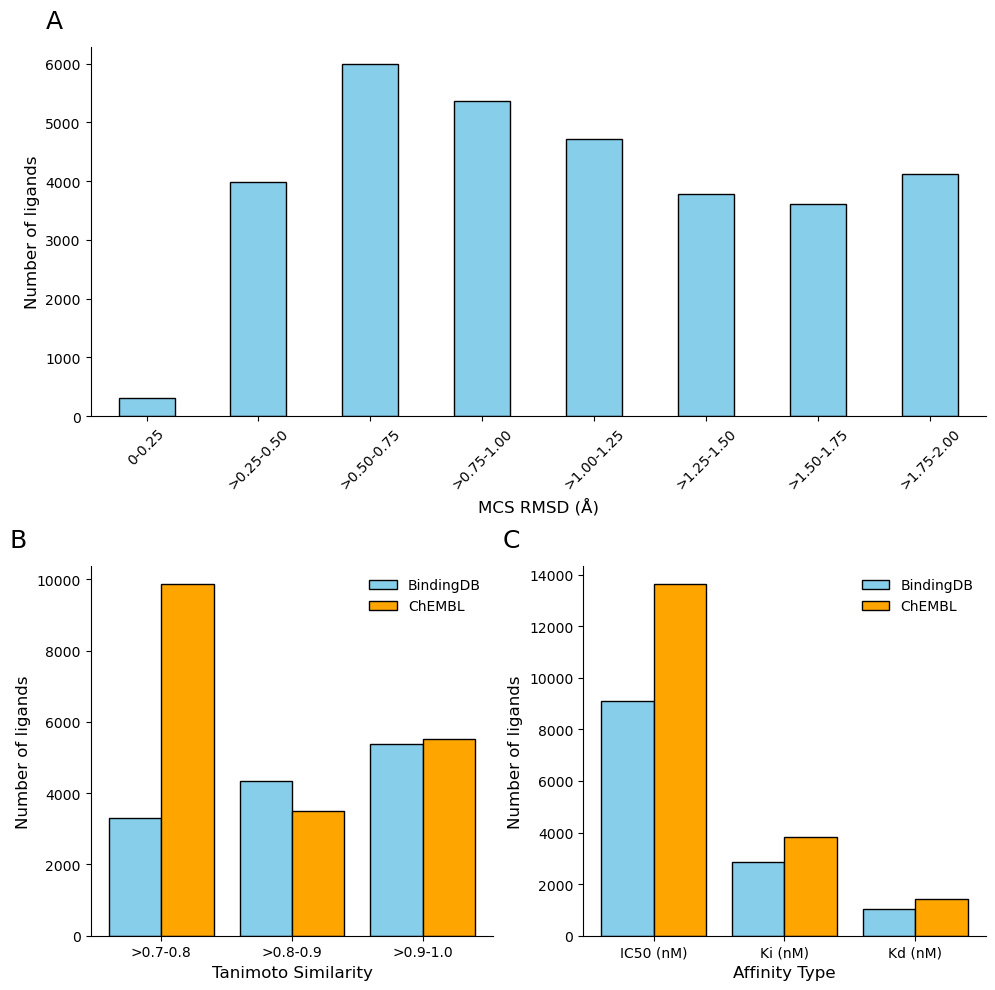

In [15]:
# Recalculate bin_counts
bins_rmsd = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, float('inf')]
labels_rmsd = ['0-0.25', '>0.25-0.50', '>0.50-0.75', 
               '>0.75-1.00', '>1.00-1.25', '>1.25-1.50', 
               '>1.50-1.75', '>1.75-2.00']

dockbind_baff['RMSD_bin'] = pd.cut(
    dockbind_baff['mcs_rmsd'],
    bins=bins_rmsd,
    labels=labels_rmsd,
    include_lowest=True,
    right=True
)

bin_counts = dockbind_baff['RMSD_bin'].value_counts().sort_index()

# Plot
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1])

# A: RMSD bin distribution
ax0 = fig.add_subplot(gs[0, :])
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax0)
ax0.set_xlabel("MCS RMSD (Å)", fontsize=12)
ax0.set_ylabel("Number of ligands", fontsize=12)
ax0.set_xticklabels(bin_counts.index, rotation=45)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.text(-0.05, 1.05, 'A', fontsize=18, transform=ax0.transAxes)

# B: Tanimoto Similarity
ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(centers - bar_width_similarity/2, counts_bdb, width=bar_width_similarity, color='skyblue', edgecolor='black', label='BindingDB')
ax1.bar(centers + bar_width_similarity/2, counts_chembl, width=bar_width_similarity, color='orange', edgecolor='black', label='ChEMBL')
ax1.set_xticks(centers)
ax1.set_xticklabels(labels, fontsize=10)
ax1.set_xlabel("Tanimoto Similarity", fontsize=12)
ax1.set_ylabel("Number of ligands", fontsize=12)
ax1.legend(frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.text(-0.2, 1.05, 'B', fontsize=18, transform=ax1.transAxes)

# C: Affinity Type
ax2 = fig.add_subplot(gs[1, 1])
x = np.arange(len(affinity_types))
ax2.bar(x - bar_width_affinity/2, bdb_vals, width=bar_width_affinity, label='BindingDB', color='skyblue', edgecolor='black')
ax2.bar(x + bar_width_affinity/2, chembl_vals, width=bar_width_affinity, label='ChEMBL', color='orange', edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(affinity_types, rotation=0)
ax2.set_xlabel("Affinity Type", fontsize=12)
ax2.set_ylabel("Number of ligands", fontsize=12)
ax2.legend(frameon=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.text(-0.2, 1.05, 'C', fontsize=18, transform=ax2.transAxes)

plt.tight_layout()
plt.savefig('../images/combined_affinity_rmsd_tanimoto.png', dpi=300, bbox_inches='tight')
plt.show()


Affinity types counts

In [16]:
print(sum(bdb_vals))
for i in bdb_vals:
    print(f'{i} ({i/sum(bdb_vals)})')

12992
9086 (0.6993534482758621)
2857 (0.2199045566502463)
1049 (0.08074199507389163)


In [17]:
print(sum(chembl_vals))
for i in chembl_vals:
    print(f'{i} ({i/sum(chembl_vals)})')

18895
13649 (0.7223604128076211)
3833 (0.2028578989150569)
1413 (0.07478168827732204)


In [18]:
dockbind_baff.groupby('Affinity_Type').size()

Affinity_Type
IC50 (nM)    22735
Kd (nM)       2462
Ki (nM)       6690
dtype: int64

Tanimoto Similarity counts

In [19]:
for i in counts_bdb:
    print(f'{i} ({i/sum(counts_bdb)})')

3292 (0.2533866995073892)
4332 (0.333435960591133)
5368 (0.4131773399014778)


In [22]:
for i in counts_chembl:
    print(f'{i} ({i/sum(counts_chembl)})')

9879 (0.5228367292934639)
3503 (0.18539296110082032)
5513 (0.2917703096057158)


In [25]:
len(dockbind_baff.UniProt_ID.unique())

626

# Chemical space visualization

In [9]:
df_pdbbind = pd.read_csv('../data/PDBbind_dataset.csv')
df_pdbbind

,Complex_ID,SMILES,Source
0,6ayo,CCC[C@H]1C[N@@H+](Cc2c[nH]c3c(N)ncnc23)C[C@@H]1O,PDBbind
1,2pqc,C[C@](O[C@@H]1CC(C(=O)[O-])=C[C@@H](OP(=O)([O-...,PDBbind
2,1oyt,NC(=[NH2+])c1ccc([C@H]2[C@H]3C(=O)N(Cc4ccc(F)c...,PDBbind
3,2q1q,NS(=O)(=O)c1ccc(N2CCCCS2(=O)=O)cc1,PDBbind
4,2yix,CCNC(=O)NCc1ccccc1Sc1ccc2nnc(C(C)C)n2c1,PDBbind
...,...,...,...
5300,4re2,OC[C@@H]1[C@@H](O)[C@H](O)[C@H](O)c2nccn21,PDBbind
5301,5f1h,COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1C[NH+](C)C,PDBbind
5302,4qge,COc1ccc(NC(=O)[C@@H](C)Nc2nc3c(cnn3C3CCCC3)c(=...,PDBbind
5303,5c28,Cc1c(N)nc(C2CC2)nc1Cl,PDBbind


In [10]:
dockbind_all = dockbind_baff[['BM_Smiles']]
dockbind_all = dockbind_all.rename(columns={'BM_Smiles': 'SMILES'})
dockbind_all['Source'] = 'DockBind'
dockbind_all

,SMILES,Source
0,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,DockBind
1,c1ccc2c(c1)c(c(s2)C(=O)NO)Cl,DockBind
2,Cn1cc(c2c1cccc2)CNCC3CCN(CC3)c4ncc(cn4)C(=O)NO,DockBind
3,COc1ccc(cc1)Cn2ccc3c2cc(cc3)C(=O)NO,DockBind
4,c1ccc(cc1)SCn2cc(nn2)c3cccc(c3)C(=O)NO,DockBind
...,...,...
31882,CC(=O)Nc1ccc(cc1)OC[C@@](C)(C(=O)Nc2ccc(c(c2)C...,DockBind
31883,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,DockBind
31884,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,DockBind
31885,C[C@](COc1ccc(cc1)C#N)(C(=O)Nc2ccc(c(c2)C(F)(F...,DockBind


In [11]:
dockbind_kdki = dockbind_baff[dockbind_baff.Affinity_Type != 'IC50 (nM)'].reset_index(drop=True)
dockbind_kdki = dockbind_kdki[['BM_Smiles']]
dockbind_kdki = dockbind_kdki.rename(columns={'BM_Smiles': 'SMILES'})
dockbind_kdki['Source'] = 'DockBind'
dockbind_kdki

,SMILES,Source
0,CC1=NC2=C(CSCC2)C(=O)N1,DockBind
1,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2C[N@]1...,DockBind
2,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2C[N@]1...,DockBind
3,c1ccc(cc1)S(=O)(=O)[N@@](CC(F)(F)F)c2ccc(cc2)C...,DockBind
4,c1cc(cc(c1)C(F)(F)P(=O)(O)O)c2cccc(c2O)C3CCCCC3,DockBind
...,...,...
9147,CC(=O)Nc1ccc(cc1)OC[C@@](C)(C(=O)Nc2ccc(c(c2)C...,DockBind
9148,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,DockBind
9149,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,DockBind
9150,C[C@](COc1ccc(cc1)C#N)(C(=O)Nc2ccc(c(c2)C(F)(F...,DockBind


In [12]:
df_all = pd.concat([dockbind_kdki, df_pdbbind[['SMILES', 'Source']]], ignore_index=True)
df_all["Mol"] = df_all["SMILES"].apply(Chem.MolFromSmiles)
df_all


,SMILES,Source,Mol
0,CC1=NC2=C(CSCC2)C(=O)N1,DockBind,<rdkit.Chem.rdchem.Mol object at 0x7fc50c5eeb20>
1,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2C[N@]1...,DockBind,<rdkit.Chem.rdchem.Mol object at 0x7fc50c5eee30>
2,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2C[N@]1...,DockBind,<rdkit.Chem.rdchem.Mol object at 0x7fc50c5eece0>
3,c1ccc(cc1)S(=O)(=O)[N@@](CC(F)(F)F)c2ccc(cc2)C...,DockBind,<rdkit.Chem.rdchem.Mol object at 0x7fc50c5eeab0>
4,c1cc(cc(c1)C(F)(F)P(=O)(O)O)c2cccc(c2O)C3CCCCC3,DockBind,<rdkit.Chem.rdchem.Mol object at 0x7fc50c5eed50>
...,...,...,...
14452,OC[C@@H]1[C@@H](O)[C@H](O)[C@H](O)c2nccn21,PDBbind,<rdkit.Chem.rdchem.Mol object at 0x7fc50d1555b0>
14453,COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1C[NH+](C)C,PDBbind,<rdkit.Chem.rdchem.Mol object at 0x7fc50d155620>
14454,COc1ccc(NC(=O)[C@@H](C)Nc2nc3c(cnn3C3CCCC3)c(=...,PDBbind,<rdkit.Chem.rdchem.Mol object at 0x7fc50d155690>
14455,Cc1c(N)nc(C2CC2)nc1Cl,PDBbind,<rdkit.Chem.rdchem.Mol object at 0x7fc50d155700>


In [13]:
fps = [AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(m)
       for m in df_all["Mol"] if m is not None]
fps_array = np.array([np.array(fp) for fp in fps])

In [14]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(fps_array)

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.20745191e-15 1.22416990e-06 1.29438084e-06 1.74065251e-05]
not reaching the requested tolerance 2.8759241104125977e-06.
Use iteration 668 instead with accuracy 
1.9909117789728292e-06.

  _, diffusion_map = lobpcg(
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 


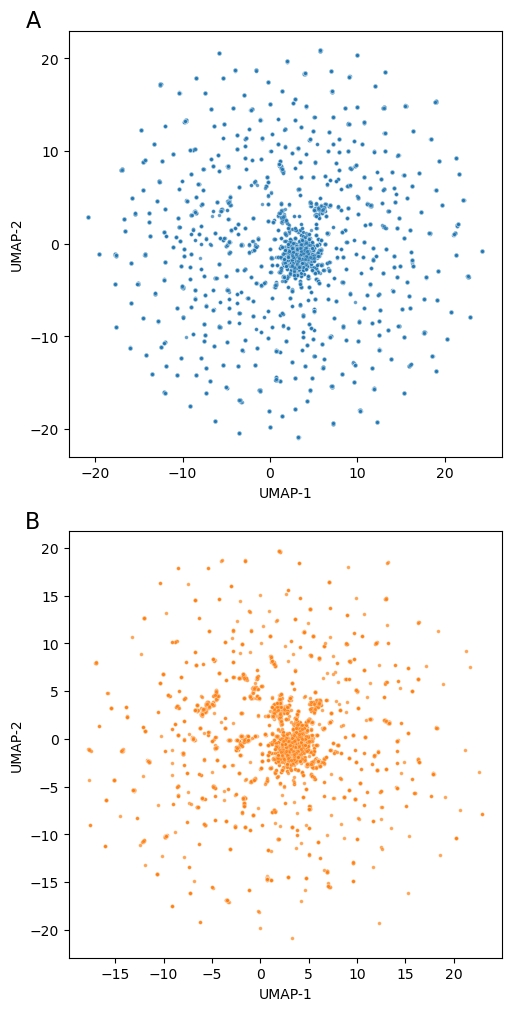

In [15]:
df_all[['UMAP_1', 'UMAP_2']] = embedding

sources = df_all['Source'].unique()
colors = {"DockBind": "blue", "PDBbind": "red"}
plot_labels = ['A', 'B']
               
fig, axes = plt.subplots(2, 1, figsize=(5, 10), constrained_layout=True)

# Panel A: DockBind
df_dockbind = df_all[df_all["Source"] == "DockBind"]
sns.scatterplot(data=df_dockbind, x='UMAP_1', y='UMAP_2', alpha=0.7, s=7, ax=axes[0], color='#1f77b4')  # navy blue
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
axes[0].text(-0.1, 1.05, 'A', fontsize=16, ha='left', va='top', transform=axes[0].transAxes)

# Panel B: PDBbind
df_pdbbind = df_all[df_all["Source"] == "PDBbind"]
sns.scatterplot(data=df_pdbbind, x='UMAP_1', y='UMAP_2', alpha=0.7, s=7, ax=axes[1], color='#ff7f0e')  # dark orange
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")
axes[1].text(-0.1, 1.05, 'B', fontsize=16, ha='left', va='top', transform=axes[1].transAxes)

plt.savefig('../images/chemical_space.png', dpi=300, bbox_inches='tight')

plt.show()

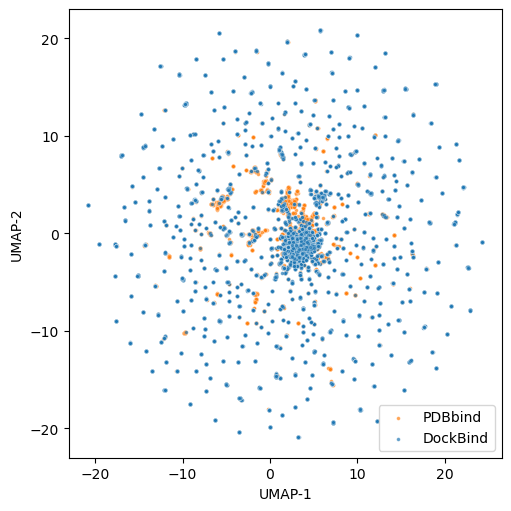

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

# Panel B: PDBbind
df_pdbbind = df_all[df_all["Source"] == "PDBbind"]
sns.scatterplot(data=df_pdbbind, x='UMAP_1', y='UMAP_2', label='PDBbind', alpha=0.7, s=7, ax=ax, color='#ff7f0e')

# Panel A: DockBind
df_dockbind = df_all[df_all["Source"] == "DockBind"]
sns.scatterplot(data=df_dockbind, x='UMAP_1', y='UMAP_2', label='DockBind', alpha=0.7, s=7, ax=ax, color='#1f77b4')
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.legend(loc='lower right')
# Save or show
plt.savefig('../images/dock_bind_pdbbind_chemical_space.png', dpi=300, bbox_inches='tight')
plt.show()

# Affinity distribution

In [50]:
df_pdbbind = pd.read_csv('../data/PDBbind_dataset.csv')

pdbbind_affinity = pd.read_csv(
    '../../../../Downloads/PDBbind_v2020_plain_text_index/index/INDEX_refined_data.2020',
    delim_whitespace=True,
    comment="#",
    header=None,
    names=["PDB_code", "Resolution", "Year", "Kd_Ki", "--", "PDF_info", "Ligand"])

# Split 'Kd_Ki' into Type and Affinity
pdbbind_affinity[['Type', 'Affinity']] = pdbbind_affinity['Kd_Ki'].str.split('=', expand=True)

# Extract numeric value and unit from 'Affinity' column without dropping other columns
pdbbind_affinity[['Affinity_value', 'Affinity_unit']] = pdbbind_affinity['Affinity'].str.extract(r'([\d\.]+)([a-zA-Z]+)')

# Convert numeric part to float
pdbbind_affinity['Affinity_value'] = pdbbind_affinity['Affinity_value'].astype(float)

conversion_to_nM = {'mM': 1000000,
                    'uM': 1000,
                    'nM': 1,
                    'pM': 0.001,
                    'fM': 0.000001}

pdbbind_affinity['Affinity_nM'] = pdbbind_affinity.apply(lambda row: row['Affinity_value'] * conversion_to_nM.get(row['Affinity_unit'], 1), axis=1)

pdbbind_affinity = pdbbind_affinity.drop(columns=['PDB_code', 'Resolution', 'Year', 'Affinity', 'Affinity_value',
                                        'Kd_Ki', '--', 'PDF_info', 'Ligand', 'Affinity_unit'])


/tmp/ipykernel_186971/3120126960.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pdbbind_affinity = pd.read_csv(


In [51]:
pdbbind_affinity = pdbbind_affinity.reset_index()
pdbbind_affinity.rename(columns={'index': 'Complex_ID'}, inplace=True)

pdbbind_affinity = pd.merge(df_pdbbind, pdbbind_affinity, on='Complex_ID', how='left')

pdbbind_affinity


,Complex_ID,SMILES,Source,Type,Affinity_nM
0,6ayo,CCC[C@H]1C[N@@H+](Cc2c[nH]c3c(N)ncnc23)C[C@@H]1O,PDBbind,Ki,5.1
1,2pqc,C[C@](O[C@@H]1CC(C(=O)[O-])=C[C@@H](OP(=O)([O-...,PDBbind,Kd,1800.0
2,1oyt,NC(=[NH2+])c1ccc([C@H]2[C@H]3C(=O)N(Cc4ccc(F)c...,PDBbind,Ki,57.0
3,2q1q,NS(=O)(=O)c1ccc(N2CCCCS2(=O)=O)cc1,PDBbind,Ki,7.0
4,2yix,CCNC(=O)NCc1ccccc1Sc1ccc2nnc(C(C)C)n2c1,PDBbind,Kd,3.3
...,...,...,...,...,...
5300,4re2,OC[C@@H]1[C@@H](O)[C@H](O)[C@H](O)c2nccn21,PDBbind,Ki,10400.0
5301,5f1h,COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1C[NH+](C)C,PDBbind,Kd,14.1
5302,4qge,COc1ccc(NC(=O)[C@@H](C)Nc2nc3c(cnn3C3CCCC3)c(=...,PDBbind,Ki,0.5
5303,5c28,Cc1c(N)nc(C2CC2)nc1Cl,PDBbind,Ki,2200.0


In [52]:
dockbind_baff = dockbind_baff[dockbind_baff.Binding_Affinity > 0]
dockbind_baff

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score,BM_Smiles,Docked_Smiles,Tanimoto_Similarity,Source,Affinity_Type,Binding_Affinity,RMSD_bin
0,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,3.459793e+04,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,CN(C)c1ccc(C(=O)NCCCCCCC(=O)NO)cc1,1.0,CHEMBL,IC50 (nM),3162.28,>1.00-1.25
1,A5H660,4BZ9_KMY,CHEMBL2094337,19,1.253,1.857755e+07,c1ccc2c(c1)c(c(s2)C(=O)NO)Cl,O=C(NO)c1sc2ccccc2c1Cl,1.0,CHEMBL,IC50 (nM),4332.58,>1.25-1.50
2,A5H660,6HSH_GOK,CHEMBL2105763,19,1.611,2.167610e+07,Cn1cc(c2c1cccc2)CNCC3CCN(CC3)c4ncc(cn4)C(=O)NO,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,1.0,CHEMBL,IC50 (nM),303.40,>1.50-1.75
3,A5H660,6HQY_GKW,CHEMBL2170177,14,0.478,2.243186e+06,COc1ccc(cc1)Cn2ccc3c2cc(cc3)C(=O)NO,COc1ccc(Cn2ccc3ccc(C(=O)NO)cc32)cc1,1.0,CHEMBL,IC50 (nM),435.80,>0.25-0.50
4,A5H660,6HRQ_GM5,CHEMBL2178342,27,0.518,1.702682e+03,c1ccc(cc1)SCn2cc(nn2)c3cccc(c3)C(=O)NO,O=C(NO)c1cccc(-c2cn(CSc3ccccc3)nn2)c1,1.0,CHEMBL,IC50 (nM),95.40,>0.50-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31882,P10275,3B68_B68,BINDINGDB18665,18,0.932,2.490645e+01,CC(=O)Nc1ccc(cc1)OC[C@@](C)(C(=O)Nc2ccc(c(c2)C...,CC(=O)Nc1ccc(OC[C@](C)(O)C(=O)Nc2ccc(c(c2)C(F)...,1.0,BINDINGDB,Ki (nM),4.00,>0.75-1.00
31883,P10275,2AX8_FHM,BINDINGDB18664,2,0.995,2.080278e+02,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,C[C@@](O)(COc1ccc(F)cc1)C(=O)Nc1ccc(c(c1)C(F)(...,1.0,BINDINGDB,Ki (nM),6.00,>0.75-1.00
31884,P10275,2AX7_FHM,BINDINGDB18663,13,0.627,3.065201e+01,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,C[C@](O)(COc1ccc(F)cc1)C(=O)Nc1ccc(c(c1)C(F)(F...,1.0,BINDINGDB,Ki (nM),6.10,>0.50-0.75
31885,P10275,3RLJ_RLJ,BINDINGDB50529668,6,0.390,7.599623e+01,C[C@](COc1ccc(cc1)C#N)(C(=O)Nc2ccc(c(c2)C(F)(F...,C[C@](O)(COc1ccc(cc1)C#N)C(=O)Nc1ccc(C#N)c(c1)...,1.0,BINDINGDB,Ki (nM),3.80,>0.25-0.50


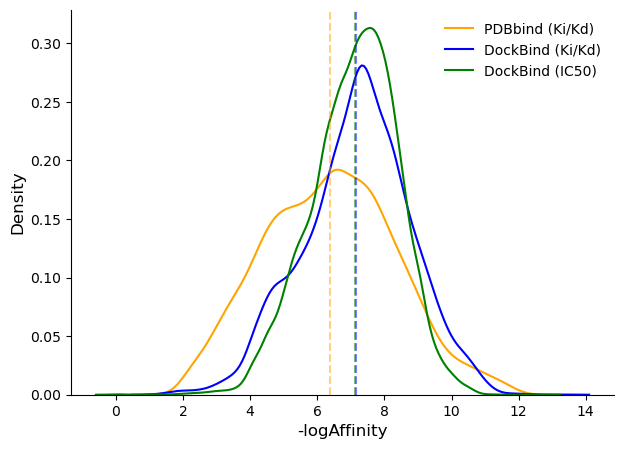

In [53]:
def compute_log_affinity(affinity_nM):

    affinity_M = affinity_nM * 1e-9
    
    return -np.log10(affinity_M)

dockbind_baff['log_affinity'] = dockbind_baff['Binding_Affinity'].apply(compute_log_affinity)
pdbbind_affinity['log_affinity'] = pdbbind_affinity['Affinity_nM'].apply(compute_log_affinity)

plt.figure(figsize=(7,5))

no_ic50 = dockbind_baff[dockbind_baff['Affinity_Type'] != 'IC50 (nM)']
ic50 = dockbind_baff[dockbind_baff['Affinity_Type'] == 'IC50 (nM)']

sns.kdeplot(pdbbind_affinity['log_affinity'], color='orange', label='PDBbind (Ki/Kd)')
sns.kdeplot(no_ic50['log_affinity'], color='blue', label='DockBind (Ki/Kd)')
sns.kdeplot(ic50['log_affinity'], color='green', label='DockBind (IC50)')

plt.axvline(pdbbind_affinity.log_affinity.mean(), color='orange', alpha=0.5, linestyle='--')
plt.axvline(no_ic50.log_affinity.mean(), color='blue', alpha=0.5, linestyle='--')
plt.axvline(ic50.log_affinity.mean(), color='green', alpha=0.5, linestyle='--')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.xlabel('-logAffinity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10, frameon=False)

plt.savefig('../images/logaffinity.png', dpi=300, bbox_inches='tight')

plt.show()

In [54]:
log_aff_df = pd.DataFrame()

log_aff_df['PDBbind_Ki_Kd'] = pdbbind_affinity.log_affinity.describe()
log_aff_df['DockBind_Ki_Kd'] = no_ic50.log_affinity.describe()
log_aff_df['DockBind_IC50'] = ic50.log_affinity.describe()

In [55]:
log_aff_df

,PDBbind_Ki_Kd,DockBind_Ki_Kd,DockBind_IC50
count,5305.000000,9152.000000,22735.000000
mean,6.389969,7.163494,7.112819
std,1.950328,1.599769,1.288574
min,1.995679,1.243364,-0.079200
25%,4.934420,6.161623,6.270835
50%,6.420216,7.259637,7.214670
75%,7.744727,8.221849,8.017729
max,11.920819,13.327902,12.721246


In [61]:
dockbind_baff.drop_duplicates(subset=['UniProt_ID', 'Docked'])

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score,BM_Smiles,Docked_Smiles,Tanimoto_Similarity,Source,Affinity_Type,Binding_Affinity,RMSD_bin,log_affinity
0,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,3.459793e+04,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,CN(C)c1ccc(C(=O)NCCCCCCC(=O)NO)cc1,1.0,CHEMBL,IC50 (nM),3162.28,>1.00-1.25,5.500000
1,A5H660,4BZ9_KMY,CHEMBL2094337,19,1.253,1.857755e+07,c1ccc2c(c1)c(c(s2)C(=O)NO)Cl,O=C(NO)c1sc2ccccc2c1Cl,1.0,CHEMBL,IC50 (nM),4332.58,>1.25-1.50,5.363253
2,A5H660,6HSH_GOK,CHEMBL2105763,19,1.611,2.167610e+07,Cn1cc(c2c1cccc2)CNCC3CCN(CC3)c4ncc(cn4)C(=O)NO,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,1.0,CHEMBL,IC50 (nM),303.40,>1.50-1.75,6.517984
3,A5H660,6HQY_GKW,CHEMBL2170177,14,0.478,2.243186e+06,COc1ccc(cc1)Cn2ccc3c2cc(cc3)C(=O)NO,COc1ccc(Cn2ccc3ccc(C(=O)NO)cc32)cc1,1.0,CHEMBL,IC50 (nM),435.80,>0.25-0.50,6.360713
4,A5H660,6HRQ_GM5,CHEMBL2178342,27,0.518,1.702682e+03,c1ccc(cc1)SCn2cc(nn2)c3cccc(c3)C(=O)NO,O=C(NO)c1cccc(-c2cn(CSc3ccccc3)nn2)c1,1.0,CHEMBL,IC50 (nM),95.40,>0.50-0.75,7.020452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31879,P10275,2AX9_BHM,BINDINGDB18699,2,1.309,1.321239e+05,C[C@](CBr)(C(=O)Nc1ccc(c(c1)C(F)(F)F)[N+](=O)[...,C[C@](O)(CBr)C(=O)Nc1ccc(c(c1)C(F)(F)F)[N+]([O...,1.0,BINDINGDB,Ki (nM),0.30,>1.25-1.50,9.522879
31882,P10275,3B68_B68,BINDINGDB18665,18,0.932,2.490645e+01,CC(=O)Nc1ccc(cc1)OC[C@@](C)(C(=O)Nc2ccc(c(c2)C...,CC(=O)Nc1ccc(OC[C@](C)(O)C(=O)Nc2ccc(c(c2)C(F)...,1.0,BINDINGDB,Ki (nM),4.00,>0.75-1.00,8.397940
31883,P10275,2AX8_FHM,BINDINGDB18664,2,0.995,2.080278e+02,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,C[C@@](O)(COc1ccc(F)cc1)C(=O)Nc1ccc(c(c1)C(F)(...,1.0,BINDINGDB,Ki (nM),6.00,>0.75-1.00,8.221849
31884,P10275,2AX7_FHM,BINDINGDB18663,13,0.627,3.065201e+01,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,C[C@](O)(COc1ccc(F)cc1)C(=O)Nc1ccc(c(c1)C(F)(F...,1.0,BINDINGDB,Ki (nM),6.10,>0.50-0.75,8.214670


In [62]:
len(dockbind_baff.UniProt_ID.unique())

626

In [63]:
dockbind_baff

,UniProt_ID,BM_Template,Docked,Pose_ID,mcs_rmsd,Hyde_score,BM_Smiles,Docked_Smiles,Tanimoto_Similarity,Source,Affinity_Type,Binding_Affinity,RMSD_bin,log_affinity
0,A5H660,4BZ7_B3N,CHEMBL140000,15,1.153,3.459793e+04,CN(C)c1ccc(cc1)C(=O)NCCCCCCC(=O)NO,CN(C)c1ccc(C(=O)NCCCCCCC(=O)NO)cc1,1.0,CHEMBL,IC50 (nM),3162.28,>1.00-1.25,5.500000
1,A5H660,4BZ9_KMY,CHEMBL2094337,19,1.253,1.857755e+07,c1ccc2c(c1)c(c(s2)C(=O)NO)Cl,O=C(NO)c1sc2ccccc2c1Cl,1.0,CHEMBL,IC50 (nM),4332.58,>1.25-1.50,5.363253
2,A5H660,6HSH_GOK,CHEMBL2105763,19,1.611,2.167610e+07,Cn1cc(c2c1cccc2)CNCC3CCN(CC3)c4ncc(cn4)C(=O)NO,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,1.0,CHEMBL,IC50 (nM),303.40,>1.50-1.75,6.517984
3,A5H660,6HQY_GKW,CHEMBL2170177,14,0.478,2.243186e+06,COc1ccc(cc1)Cn2ccc3c2cc(cc3)C(=O)NO,COc1ccc(Cn2ccc3ccc(C(=O)NO)cc32)cc1,1.0,CHEMBL,IC50 (nM),435.80,>0.25-0.50,6.360713
4,A5H660,6HRQ_GM5,CHEMBL2178342,27,0.518,1.702682e+03,c1ccc(cc1)SCn2cc(nn2)c3cccc(c3)C(=O)NO,O=C(NO)c1cccc(-c2cn(CSc3ccccc3)nn2)c1,1.0,CHEMBL,IC50 (nM),95.40,>0.50-0.75,7.020452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31882,P10275,3B68_B68,BINDINGDB18665,18,0.932,2.490645e+01,CC(=O)Nc1ccc(cc1)OC[C@@](C)(C(=O)Nc2ccc(c(c2)C...,CC(=O)Nc1ccc(OC[C@](C)(O)C(=O)Nc2ccc(c(c2)C(F)...,1.0,BINDINGDB,Ki (nM),4.00,>0.75-1.00,8.397940
31883,P10275,2AX8_FHM,BINDINGDB18664,2,0.995,2.080278e+02,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,C[C@@](O)(COc1ccc(F)cc1)C(=O)Nc1ccc(c(c1)C(F)(...,1.0,BINDINGDB,Ki (nM),6.00,>0.75-1.00,8.221849
31884,P10275,2AX7_FHM,BINDINGDB18663,13,0.627,3.065201e+01,C[C@](COc1ccc(cc1)F)(C(=O)Nc2ccc(c(c2)C(F)(F)F...,C[C@](O)(COc1ccc(F)cc1)C(=O)Nc1ccc(c(c1)C(F)(F...,1.0,BINDINGDB,Ki (nM),6.10,>0.50-0.75,8.214670
31885,P10275,3RLJ_RLJ,BINDINGDB50529668,6,0.390,7.599623e+01,C[C@](COc1ccc(cc1)C#N)(C(=O)Nc2ccc(c(c2)C(F)(F...,C[C@](O)(COc1ccc(cc1)C#N)C(=O)Nc1ccc(C#N)c(c1)...,1.0,BINDINGDB,Ki (nM),3.80,>0.25-0.50,8.420216


In [64]:
dockbind_baff = dockbind_baff.drop(columns='RMSD_bin')
dockbind_baff.to_csv('../data/DockBind_w_affinities.csv', index=False)